In [1]:
import wrf
import netCDF4 as nc
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import datetime as dt
import metpy.calc as mpcalc

def calc_grad_theta(theta):
    theta_np = theta.values
    dx, dy = mpcalc.lat_lon_grid_deltas(theta.XLONG.values, theta.XLAT.values)
    dtheta_dy, dtheta_dx = mpcalc.gradient(theta_np, deltas=[dy.to("km"), dx.to("km")])
    grad_theta = dtheta_dy + dtheta_dx
    grad_theta = xr.DataArray(grad_theta.data,dims=["south_north","west_east"])
    grad_theta["XLONG"] = theta.XLONG
    return grad_theta

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

In [2]:
f = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_03:30:00"
wrflist = nc.Dataset(f)

In [3]:
wspd_wdir = wrf.getvar(wrflist, "wspd_wdir10")
wspd = wspd_wdir.isel(wspd_wdir=0)
wdir = wspd_wdir.isel(wspd_wdir=1)
uvmet10 = wrf.getvar(wrflist, "uvmet10")
u10 = uvmet10.isel(u_v=0).drop_vars("u_v")
v10 = uvmet10.isel(u_v=1).drop_vars("u_v")
theta = wrf.getvar(wrflist, "theta").isel(bottom_top=0)
theta_3d = wrf.getvar(wrflist, "theta")
heights = wrf.getvar(wrflist,"z")
wspd_wdir_3d = wrf.getvar(wrflist, "wspd_wdir")
wspd_3d = wspd_wdir_3d.isel(wspd_wdir=0)

(-37.0, -36.0)

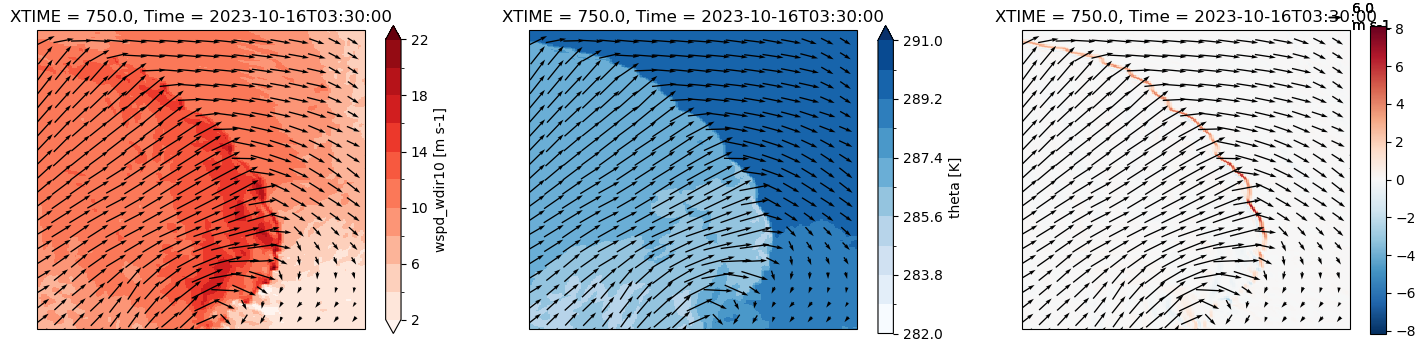

In [4]:
xlim = [153.5,154.6]
ylim = [-37,-36]
coarsen = 12
uv_ds = xr.Dataset({"u":u10,"v":v10}).coarsen(dim={"south_north":coarsen,"west_east":coarsen},boundary="trim").mean()


plt.figure(figsize=[18,4])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
wspd.plot(ax=ax,x="XLONG",y="XLAT",cmap="Reds",levels=np.linspace(2,22,11))
uv_ds.plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150,width=0.004)  
plt.xlim(xlim)
plt.ylim(ylim)

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
theta.plot(ax=ax,x="XLONG",y="XLAT",cmap="Blues",levels=np.linspace(282,291,11))
uv_ds.plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150,width=0.004)  
plt.xlim(xlim)
plt.ylim(ylim)

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())

grad_theta = calc_grad_theta(theta)
grad_theta.plot(ax=ax,x="XLONG",y="XLAT")
uv_ds.plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150,width=0.004)  
plt.xlim(xlim)
plt.ylim(ylim)

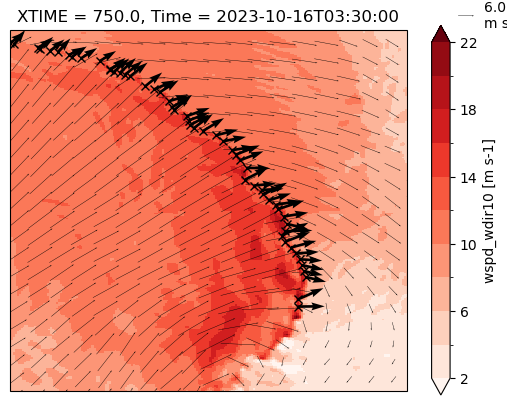

In [5]:
ax=plt.subplot(projection=ccrs.PlateCarree())
wspd.plot(ax=ax,x="XLONG",y="XLAT",cmap="Reds",levels=np.linspace(2,22,11))
uv_ds.plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150,width=0.001)  
#xr.plot.contour(grad_theta,ax=ax,x="XLONG",y="XLAT",levels=[2],colors=["k"])

plt.xlim(xlim)
plt.ylim(ylim)

step = 10
line_inds = (grad_theta.values >= 2)
line_x = grad_theta.XLONG.values[line_inds][0:-1:step]
line_y = grad_theta.XLAT.values[line_inds][0:-1:step]
plt.plot(line_x,line_y,ls="none",marker="x",color="k")

line_u = u10.values[line_inds][0:-1:step]
line_v = v10.values[line_inds][0:-1:step]
plt.quiver(line_x,line_y,line_u,line_v)

In [14]:
int(np.round((line_inds.sum() / 20.).values))

25

21  transects


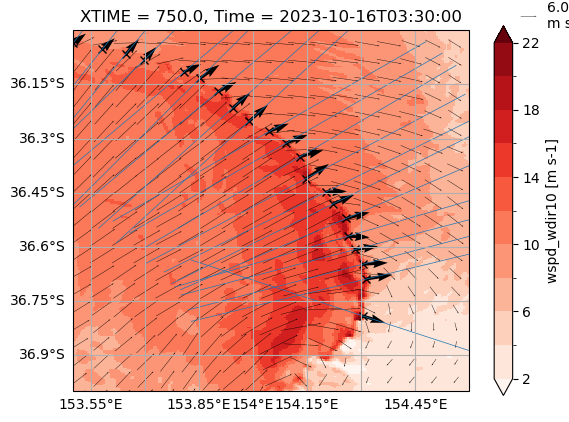

In [15]:
ax=plt.subplot(projection=ccrs.PlateCarree())
wspd.plot(ax=ax,x="XLONG",y="XLAT",cmap="Reds",levels=np.linspace(2,22,11))
uv_ds.plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150,width=0.001)  

plt.xlim(xlim)
plt.ylim(ylim)

step = int(np.round((line_inds.sum() / 20.).values)) #Plot around 20 transects along the line of grad_theta >= 2
line_inds = (grad_theta.values >= 2) & (grad_theta.XLONG >= xlim[0]) & (grad_theta.XLONG <= xlim[1]) & (grad_theta.XLAT >= ylim[0]) & (grad_theta.XLAT <= ylim[1])
line_x = grad_theta.XLONG.values[line_inds][0:-1:step]
line_y = grad_theta.XLAT.values[line_inds][0:-1:step]
line_u = u10.values[line_inds][0:-1:step]
line_v = v10.values[line_inds][0:-1:step]
#line_wdir = 270 - wdir.values[line_inds][0:-1:step]
line_wdir = 270 - wdir.rolling({"south_north":5,"west_east":5}).mean().values[line_inds][0:-1:step]

plt.quiver(line_x,line_y,line_u,line_v)
plt.plot(line_x,line_y,ls="none",marker="x",color="k")

print(len(line_x)," transects")
start_points = []
end_points = []
for i in range(len(line_x)):

    angle = line_wdir[i]
    D = .50 #Half a degree lat/lon
    
    end_point = [line_x[i] + D * np.cos(np.deg2rad(angle)), line_y[i] + D * np.sin(np.deg2rad(angle))]
    start_point = [line_x[i] + D * np.cos(np.deg2rad(angle-180)), line_y[i] + D * np.sin(np.deg2rad(angle-180))]
    
    
    start_points.append(start_point)
    end_points.append(end_point)    
    ax.plot([start_point[0],end_point[0]],[start_point[1],end_point[1]],lw=0.5,color="tab:blue")

ax.gridlines(draw_labels=["bottom","left"])

21  transects


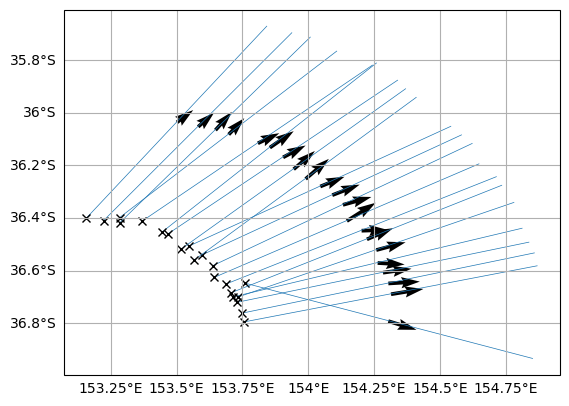

In [32]:
x = theta.west_east*wrflist.DX
y = theta.south_north*wrflist.DY
x,y=np.meshgrid(x,y)
line_x_cart = x[line_inds][0:-1:step]
line_y_cart = y[line_inds][0:-1:step]

ax=plt.subplot(projection=ccrs.PlateCarree())

print(len(line_x)," transects")
start_points = []
end_points = []
for i in range(len(line_x_cart)):

    angle = line_wdir[i]
    D = 50 * 1000 #50 km
    
    start_point = [line_y_cart[i] + D * np.sin(np.deg2rad(angle-180)), line_x_cart[i] + D * np.cos(np.deg2rad(angle-180))]
    end_point = [line_y_cart[i] + D * np.sin(np.deg2rad(angle)), line_x_cart[i] + D * np.cos(np.deg2rad(angle))]
    
    start_ind = [np.argmin(np.abs(start_point[0] - theta.west_east.values*wrflist.DX)), 
                        np.argmin(np.abs(start_point[1] - theta.south_north.values*wrflist.DY))]
    end_ind = [np.argmin(np.abs(end_point[0] - theta.west_east.values*wrflist.DX)), 
                        np.argmin(np.abs(end_point[1] - theta.south_north.values*wrflist.DY))]    
    
    start_point_lon = grad_theta.XLONG.values[start_ind[0],start_ind[1]]
    start_point_lat = grad_theta.XLAT.values[start_ind[0],start_ind[1]]
    
    end_point_lon = grad_theta.XLONG.values[end_ind[0],end_ind[1]]
    end_point_lat = grad_theta.XLAT.values[end_ind[0],end_ind[1]]
    
    start_points.append([start_point_lon,start_point_lat])
    end_points.append([end_point_lon,end_point_lat])
    
    ax.plot([start_point_lon,end_point_lon],[start_point_lat,end_point_lat],lw=0.5,color="tab:blue")
    
    ax.plot(start_point_lon,start_point_lat,marker="x",color="k")

ax.gridlines(draw_labels=["bottom","left"])

plt.quiver(line_x,line_y,line_u,line_v)

In [17]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def cross_line_km(cross,lats,lons):
    
    xy_lats = [xy.lat for xy in cross.xy_loc.values]
    xy_lons = [xy.lon for xy in cross.xy_loc.values]
    xy = np.round(latlon_dist(lats[0],lons[0],xy_lats,xy_lons),1)#.astype(str)

    return cross.assign_coords({"cross_line_idx":xy})
    
top = 12000
theta_crosses = []
wspd_crosses = []
for i in range(len(line_x)):
    
    start_point = wrf.CoordPair(lat=start_points[i][1],lon=start_points[i][0])
    end_point = wrf.CoordPair(lat=end_points[i][1],lon=end_points[i][0])    
    
    theta_cross = wrf.vertcross(theta_3d,heights,wrfin=wrflist,levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point,latlon=True)
    theta_crosses.append( cross_line_km(theta_cross,[start_point.lat,end_point.lat],[start_point.lon,end_point.lon]))
    
    wspd_cross = wrf.vertcross(wspd_3d,heights,wrfin=wrflist,levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point,latlon=True)
    wspd_crosses.append( cross_line_km(wspd_cross,[start_point.lat,end_point.lat],[start_point.lon,end_point.lon]))    
    


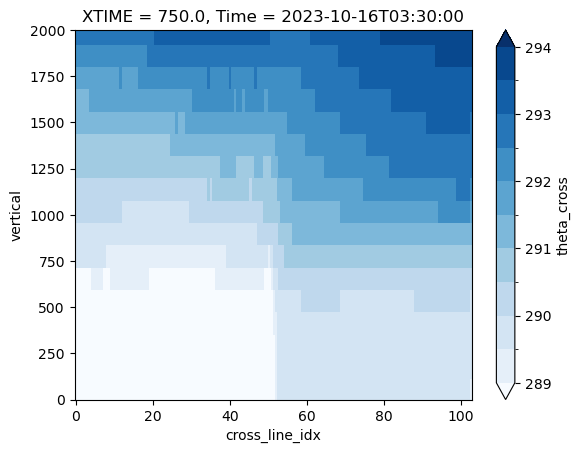

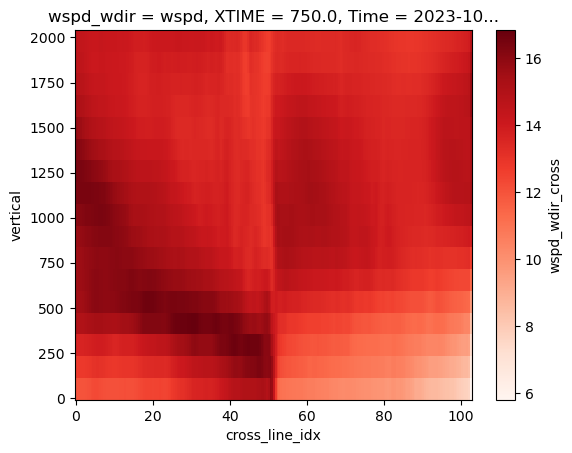

In [18]:
theta_cross = xr.concat([theta_cross.interp({"cross_line_idx":theta_crosses[0].cross_line_idx},method="nearest") for theta_cross in theta_crosses],"transect").mean("transect")
wspd_cross = xr.concat([wspd_cross.interp({"cross_line_idx":wspd_crosses[0].cross_line_idx},method="nearest") for wspd_cross in wspd_crosses],"transect").mean("transect")
theta_cross.plot(levels=np.linspace(289,294,11),cmap="Blues")
plt.ylim([0,2000])
plt.figure()
wspd_cross.sel(vertical=slice(0,2000)).plot(cmap="Reds")

In [39]:
theta_crosses[0]

<xarray.DataArray 'theta_cross' (vertical: 100, cross_line_idx: 226)>
array([[286.99765, 286.92618, 286.87405, ..., 288.65228, 288.65253,
        288.6272 ],
       [286.94998, 286.89154, 286.83948, ..., 288.70065, 288.7498 ,
        288.8117 ],
       [286.93982, 286.89938, 286.86008, ..., 288.7248 , 288.76508,
        288.86624],
       ...,
       [359.62708, 359.62534, 359.63336, ..., 361.68933, 361.71124,
        361.7212 ],
       [361.15683, 361.1822 , 361.21704, ..., 363.2114 , 363.23172,
        363.24045],
       [362.78235, 362.817  , 362.85803, ..., 364.4208 , 364.41125,
        364.391  ]], dtype=float32)
Coordinates:
    XTIME           float32 750.0
    Time            datetime64[ns] 2023-10-16T03:30:00
    xy_loc          (cross_line_idx) object CoordPair(x=232.0, y=180.0, lat=-...
  * vertical        (vertical) float32 50.0 170.7 291.4 ... 1.188e+04 1.2e+04
  * cross_line_idx  (cross_line_idx) float32 0.0 0.5 0.9 ... 101.6 102.0 102.5
Attributes:
    FieldType:      104
    description:    potential temperature
    units:          K
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     LambertConformal(stand_lon=154.3000030517578, moad_cen_la...
    orientation:    (232.0, 180.0) to (446.0, 110.0)
    missing_value:  9.969209968386869e+36
    _FillValue:     9.969209968386869e+36

'tasman_d04_20231015_20231016_ramssa_shortlead_03:30:00'